## Exploratory Data Analysis (EDA) for NYC Taxi Data
- In this notebook we will take the kaggle NYC taxi data and
    1. run through some basic EDA
    2. create some basic linear models
- [kaggle data source](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#three decimals
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
path = '/Users/kelly/Downloads/new-york-city-taxi-fare-prediction'
print(os.listdir(path))

['test.csv', 'GCP-Coupons-Instructions.rtf', 'train.csv', 'sample_submission.csv']


In [3]:
#create dataframe by reading in first million rows
df = pd.read_csv(path+'/train.csv', nrows = 1_000_000,  parse_dates = ['pickup_datetime'])

In [5]:
#datatypes
df.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [6]:
#Show first 10 rows
df.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.50000,2009-06-15 17:26:21+00:00,-73.84431,40.72132,-73.84161,40.71228,1
1,2010-01-05 16:52:16.0000002,16.90000,2010-01-05 16:52:16+00:00,-74.01605,40.71130,-73.97927,40.78200,1
2,2011-08-18 00:35:00.00000049,5.70000,2011-08-18 00:35:00+00:00,-73.98274,40.76127,-73.99124,40.75056,2
3,2012-04-21 04:30:42.0000001,7.70000,2012-04-21 04:30:42+00:00,-73.98713,40.73314,-73.99157,40.75809,1
4,2010-03-09 07:51:00.000000135,5.30000,2010-03-09 07:51:00+00:00,-73.96809,40.76801,-73.95665,40.78376,1
5,2011-01-06 09:50:45.0000002,12.10000,2011-01-06 09:50:45+00:00,-74.00096,40.73163,-73.97289,40.75823,1
6,2012-11-20 20:35:00.0000001,7.50000,2012-11-20 20:35:00+00:00,-73.98000,40.75166,-73.97380,40.76484,1
7,2012-01-04 17:22:00.00000081,16.50000,2012-01-04 17:22:00+00:00,-73.95130,40.77414,-73.99009,40.75105,1
8,2012-12-03 13:10:00.000000125,9.00000,2012-12-03 13:10:00+00:00,-74.00646,40.72671,-73.99308,40.73163,1
9,2009-09-02 01:11:00.00000083,8.90000,2009-09-02 01:11:00+00:00,-73.98066,40.73387,-73.99154,40.75814,2


In [7]:
#generate summary statistics
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.00000,1000000.00000,1000000.00000,999990.00000,999990.00000,1000000.00000
mean,11.34808,-72.52664,39.92901,-72.52786,39.91995,1.68492
std,9.82209,12.05794,7.62615,11.32449,8.20142,1.32391
min,-44.90000,-3377.68094,-3116.28538,-3383.29661,-3114.33857,0.00000
25%,6.00000,-73.99206,40.73497,-73.99138,40.73405,1.00000
50%,8.50000,-73.98179,40.75270,-73.98014,40.75317,1.00000
75%,12.50000,-73.96709,40.76715,-73.96365,40.76813,2.00000
max,500.00000,2522.27133,2621.62843,45.58162,1651.55343,208.00000


Looking at these summary statistics, we see that there are some erroneous data:

- The minimum value of the fare, i.e.,  `fare_amount`, is negative
- The min/max of both pickup and dropoff latitutes and longitutes are out of bounds
- The min and max of passengers, i.e., `passenger_counts`, are suspect

### Remove Missing Data
We'll check if there is missing entries in the data, and if so, remove them.

In [8]:
print(df.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64


In [9]:
df = df.dropna(how = 'any', axis = 'rows')

### Remove trips with non-positive fares
- In fact, we'll use some domain knowledge here: we know there is an initial price of $2.50 for the taxi.

In [10]:
#Prune for > 2.5 minimum fare
temp = len(df)
print('Old Size: %d' % len(df))
def remove_by_fare ( df ):
    return df.fare_amount >= 2.5
#df = df[df.fare_amount >= 2.5]
df = df[remove_by_fare(df)]
print('New size: %d' % len(df))
print('Diff: %d' % (temp-len(df)))

Old Size: 999990
New size: 999913
Diff: 77


## Explore test dataset

In [18]:
df_test = pd.read_csv(path+'/test.csv')
df_test.head(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.97332,40.76381,-73.98143,40.74384,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.98686,40.71938,-73.99889,40.73920,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.98252,40.75126,-73.97965,40.74614,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.98116,40.76781,-73.99045,40.75164,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.96605,40.78977,-73.98857,40.74443,1


In [19]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.00000,9914.00000,9914.00000,9914.00000,9914.00000
mean,-73.97472,40.75104,-73.97366,40.75174,1.67127
std,0.04277,0.03354,0.03907,0.03544,1.27875
min,-74.25219,40.57314,-74.26324,40.56897,1.00000
25%,-73.99250,40.73613,-73.99125,40.73525,1.00000
50%,-73.98233,40.75305,-73.98002,40.75406,1.00000
75%,-73.96801,40.76711,-73.96406,40.76876,2.00000
max,-72.98653,41.70956,-72.99096,41.69668,6.00000


### Remove trips with erroneous location data
- Our plan will be to find a rectangular region, or bounding box, containing reasonable coordinates.
- Using [open street map](https://www.openstreetmap.org/export#map=9/40.9021/-73.1772): we see that some reasonable bounds are: $$[-74.6219,-71.7325]\times [40.1264, 41.6688]$$

In [27]:
X = [min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), 
     max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())]
Y = [min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()),
     max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())]

In [28]:
X,Y
X, Y = [-74.3, -72.9], [40.5, 41.8]

In [29]:
# X = [-74.2724, -71.7325]
# Y = [40.1264, 41.6688]

In [30]:
def in_bounding_box ( df, X, Y):
    return (df . pickup_longitude >= X[0]) & (df . pickup_longitude <= X[1]) \
         & (df . pickup_latitude >= Y[0]) & (df . pickup_latitude <= Y[1]) \
         & (df . dropoff_longitude >= X[0]) & (df . dropoff_longitude <= X[1]) \
         & (df . dropoff_latitude >= Y[0]) & (df . dropoff_latitude <= Y[1])

In [31]:
temp = len(df)
print('Size: %d' % len(df))
df = df[in_bounding_box(df, X, Y)]
print('New size: %d' % len(df))
print('Difference: %d ' % (temp-len(df)))

Size: 978974
New size: 978901
Difference: 73 


In [32]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,978901.00000,978901.00000,978901.00000,978901.00000,978901.00000,978901.00000
mean,11.32527,-73.97508,40.75112,-73.97419,40.75145,1.68503
std,9.68394,0.03840,0.02951,0.03752,0.03269,1.30773
min,2.50000,-74.27186,40.50398,-74.27213,40.50198,0.00000
25%,6.00000,-73.99227,40.73658,-73.99157,40.73560,1.00000
50%,8.50000,-73.98208,40.75342,-73.98059,40.75388,1.00000
75%,12.50000,-73.96831,40.76758,-73.96532,40.76842,2.00000
max,500.00000,-72.94086,41.65000,-72.90000,41.57207,6.00000


In [86]:
# load image of NYC map
nyc_map = plt.imread('/Users/kelly/Downloads/map_small.png')

In [98]:
def plot_on_nyc_map ( df, X, Y):
    fig,axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, c='r', alpha=.2, s = 1)
    axs[0].set_xlim(X[0],X[1])
    axs[0].set_ylim(Y[0],Y[1])
    axs[0].set_title('Pickup Locations')
    axs[0].imshow(nyc_map, zorder=0, extent=X+Y)
    
    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=.2, s = 1)
    axs[1].set_xlim(X[0],X[1])
    axs[1].set_ylim(Y[0],Y[1])
    axs[1].set_title('Dropoff Locations')
    axs[1].imshow(nyc_map, zorder=0, extent=X+Y)

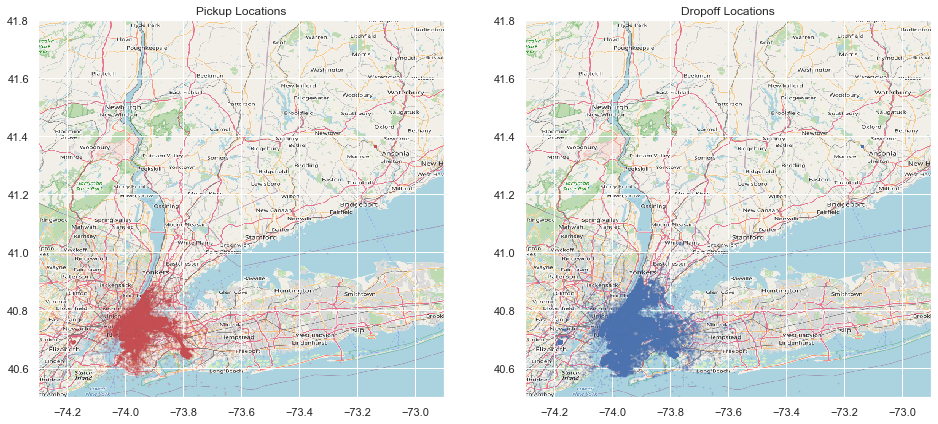

In [99]:
plot_on_nyc_map(df, X, Y)

### Histograms
- Let's check out some basic histograms for the data

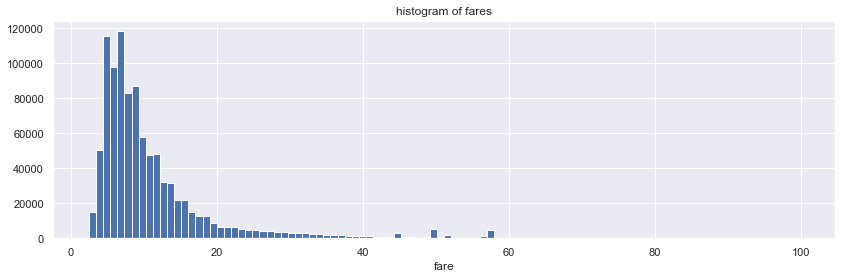

In [101]:
#plot histogram of fares
df[df.fare_amount < 100].fare_amount.hist(bins=100, figsize=(14,4))
plt.xlabel('fare')
plt.title('histogram of fares');

In [102]:
print(df.groupby('fare_amount').size().nlargest(10))

fare_amount
6.50000     47670
4.50000     40319
8.50000     36707
5.30000     28677
5.70000     28531
6.10000     27777
4.90000     27699
6.90000     25677
10.50000    24678
7.30000     23965
dtype: int64


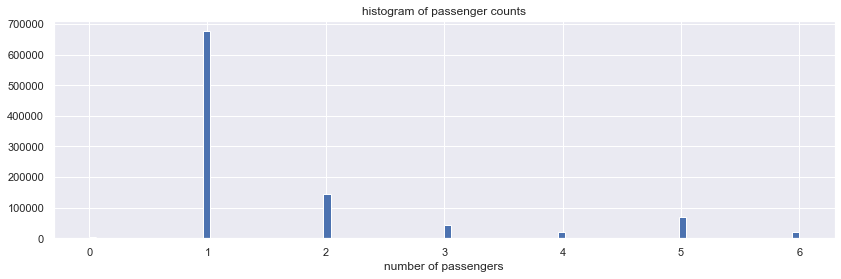

In [103]:
#plot histogram of passenger counts
df[df.passenger_count < 20].passenger_count.hist(bins=100, figsize=(14,4))
plt.xlabel('number of passengers')
plt.title('histogram of passenger counts');

In [104]:
print(df.groupby('passenger_count').size().nlargest(10))

passenger_count
1    676505
2    145214
5     69083
3     42861
4     20996
6     20760
0      3482
dtype: int64


### Remove trips with erroneous passenger counts
From the above histogram, it looks reasonable to assume that passenger counts are above 0 and 6 or fewer.

In [110]:
#df = df[df.passenger_count <= 6]
def remove_by_passenger_count ( df ):
    return (df.passenger_count > 0) & (df.passenger_count <= 6)
df = df[remove_by_passenger_count(df)]

---

### Feature Engineering: Distance (mi)
We'll add distance as a aspect of the data.  This requires calculation of the geodesic distance given the pickup and dropoff locations.  This can be determined using the haversine formula, see https://en.wikipedia.org/wiki/Haversine_formula:
$$ d = 2r\arcsin \left(
\sqrt{
\sin^2\left(\frac{\phi_2-\phi_1}{2}\right)+\cos(\phi_1)\cos(\phi_2)\sin^2\left(\frac{\lambda_2-\lambda_1}{2}\right)
}
\right)
$$
where $\phi_1,\phi_2$ are the latitudes, $\lambda_1,\lambda_2$ are the longitudes and $r$ is the radius of sphere (in this case, $r=3958.8$ as Earth has a mean radius of 3958.8 miles; see https://en.wikipedia.org/wiki/Earth)



In [111]:
def geodesic (phi_1, lam_1, phi_2, lam_2, r = 3958.8 ):
    phi_1, lam_1, phi_2, lam_2 = map(np.radians, [phi_1, lam_1, phi_2, lam_2])
    d_lats, d_longs = phi_2-phi_1, lam_2-lam_1
    a = np.sin(d_lats/2.0)**2 + np.cos(phi_1)*np.cos(phi_2)*np.sin(d_longs/2.0)**2
    return 2.0 * r * np.arcsin ( np.sqrt ( a ) )

In [112]:
def add_distance ( df ):
    df['distance'] = geodesic (df['pickup_latitude'], df['pickup_longitude'], 
                               df['dropoff_latitude'], df['dropoff_longitude'] )

In [113]:
add_distance(df)

In [114]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,975419.00000,975419.00000,975419.00000,975419.00000,975419.00000,975419.00000,975419.00000
mean,11.33459,-73.97507,40.75111,-73.97418,40.75145,1.69104,2.06847
std,9.69369,0.03843,0.02952,0.03755,0.03270,1.30617,2.33661
min,2.50000,-74.27186,40.50398,-74.27213,40.50198,1.00000,0.00000
25%,6.00000,-73.99227,40.73658,-73.99157,40.73559,1.00000,0.77930
50%,8.50000,-73.98208,40.75341,-73.98059,40.75388,1.00000,1.33799
75%,12.50000,-73.96831,40.76758,-73.96531,40.76842,2.00000,2.43493
max,500.00000,-72.94086,41.65000,-72.90000,41.57207,6.00000,68.86925


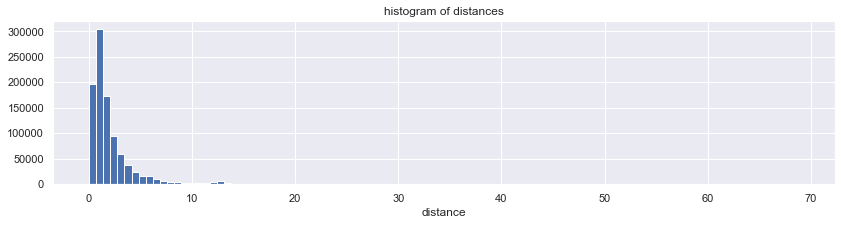

In [115]:
df.distance.hist(bins=100, figsize=(14,3))
plt.xlabel('distance')
plt.title('histogram of distances');

In [116]:
print('Old size: %d' % len(df))
df = df[df.distance > 0]
print('New size: %d' % len(df))

Old size: 975419
New size: 964963


### Scatter plot for distance v. fare
At first, it may seem reasonable assumption to  assume fare is an increasing function of distance, independent of time.  Let's check this assumption.

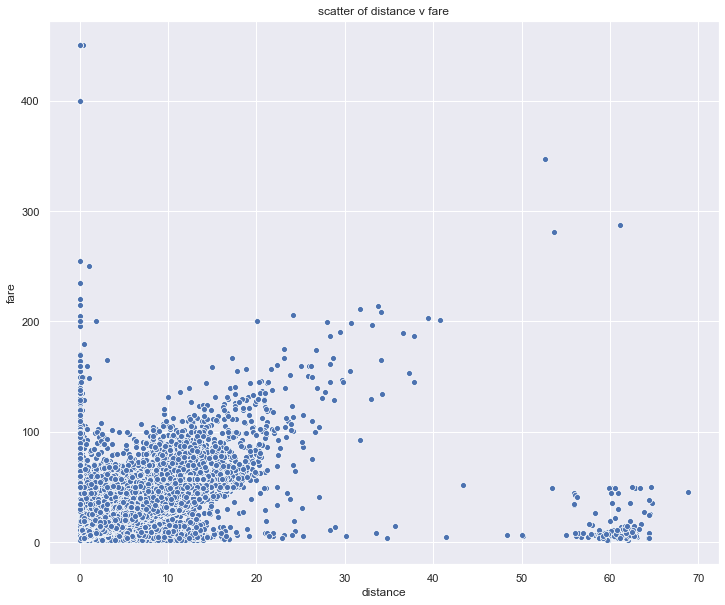

In [118]:
plt.figure(figsize=(12,10))
sns.scatterplot(x="distance", y="fare_amount", data=df)
plt.xlabel('distance')
plt.ylabel('fare')
plt.title('scatter of distance v fare');

Given this scatter plot, our assumption seems incorrect; the plot also seems to indicate we may still have erroneous data.  Let's first attempt a linear model anyway, after cleaning some more of the data.  Here are potential sources of issues:
- distance (as the crow flies) is a rough proxy for distance driven, which could be quite different (one-way streets, etc)
- Note that trips to airports are often a fixed amount, and may want to be dealt with separately.
- There are also some trips that appear to be close to zero distance, while having hundred dollar of fares.

In [119]:
df[(df.distance < .5) & (df.fare_amount > 21)].describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,1856.00000,1856.00000,1856.00000,1856.00000,1856.00000,1856.00000,1856.00000
mean,50.73990,-73.94039,40.74004,-73.94039,40.74002,1.61800,0.08524
std,32.03534,0.11481,0.06919,0.11480,0.06916,1.25854,0.13041
min,21.10000,-74.25523,40.51651,-74.25523,40.51315,1.00000,0.00005
25%,35.00000,-73.99418,40.70920,-73.99411,40.70920,1.00000,0.00134
50%,45.77000,-73.97564,40.74744,-73.97602,40.74704,1.00000,0.01343
75%,53.00000,-73.88432,40.76730,-73.88438,40.76723,2.00000,0.12413
max,450.00000,-73.01175,41.39104,-73.01178,41.39104,6.00000,0.49945


In [120]:
df = df[(df.distance > .5) | (df.fare_amount <= 21)]

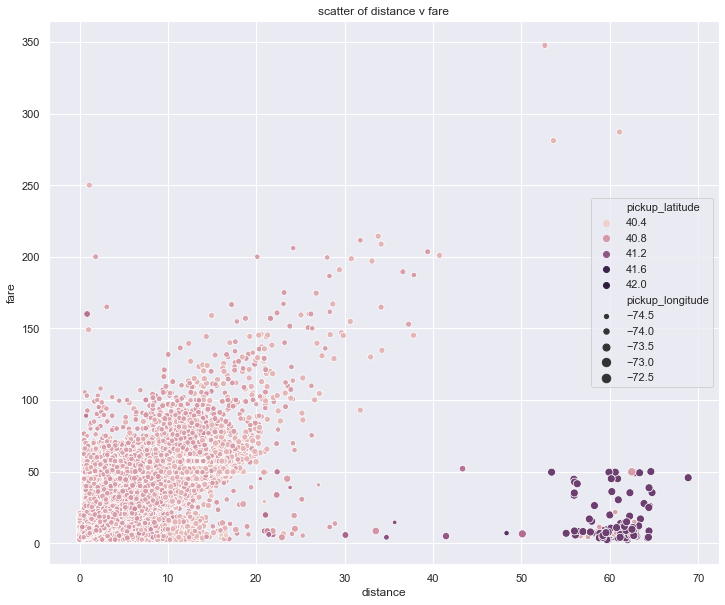

In [121]:
#df.plot.scatter(x='distance', y='fare_amount')
plt.figure(figsize=(12,10))
sns.scatterplot(x="distance", y="fare_amount", hue='pickup_latitude', size='pickup_longitude', data=df)
plt.xlabel('distance')
plt.ylabel('fare')
plt.title('scatter of distance v fare');

In [122]:
g = df[(df.distance > 40) & (df.distance < 80) & (df.fare_amount < 100)]
g.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,142.00000,142.00000,142.00000,142.00000,142.00000,142.00000,142.00000
mean,14.31162,-73.30804,41.24688,-73.80564,40.85746,1.26056,60.25027
std,13.99601,0.33406,0.24614,0.33782,0.23902,0.67034,3.51325
min,2.50000,-74.00599,40.64485,-74.13419,40.63027,1.00000,41.46845
25%,6.10000,-73.13739,41.36614,-73.98967,40.73730,1.00000,59.41999
50%,8.10000,-73.13739,41.36614,-73.97367,40.75587,1.00000,60.86324
75%,14.80000,-73.13739,41.36614,-73.86320,40.78504,1.00000,62.24014
max,52.00000,-72.94086,41.65000,-72.90000,41.36614,5.00000,68.86925


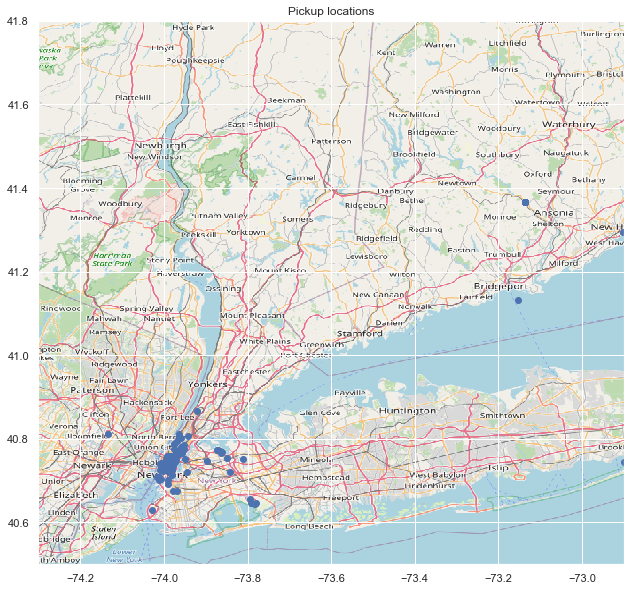

In [123]:
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(g.dropoff_longitude, g.dropoff_latitude, zorder=1, c='b')
ax.set_title('Pickup locations')
ax.set_xlim((X[0], X[1]))
ax.set_ylim((Y[0], Y[1]))
ax.imshow(nyc_map, zorder=0,extent=X+Y)

In [126]:
df = df[(df.distance < 40) | (df.fare_amount > 100)]

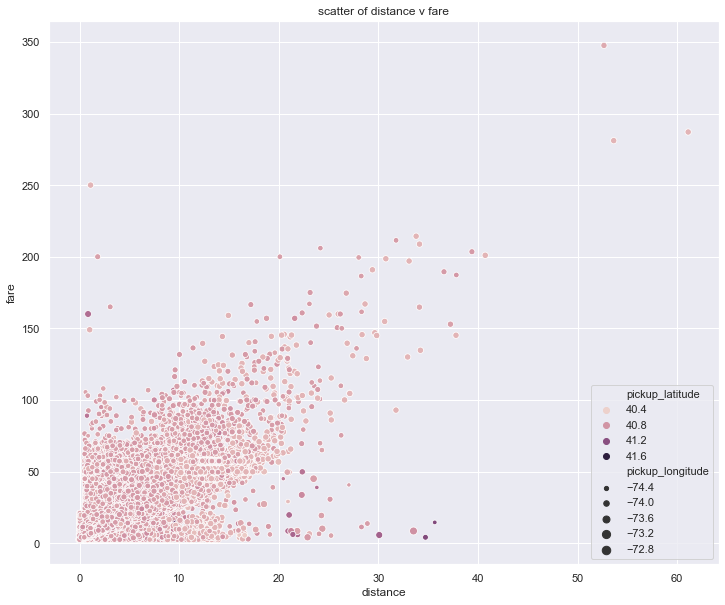

In [127]:
#df.plot.scatter(x='distance', y='fare_amount')
plt.figure(figsize=(12,10))
sns.scatterplot(x="distance", y="fare_amount", hue='pickup_latitude', size='pickup_longitude', data=df)
plt.xlabel('distance')
plt.ylabel('fare')
plt.title('scatter of distance v fare');

## Handling airport fares


- Use [open street map](https://www.openstreetmap.org/export#map=14/40.6495/-73.7865) to get bounding box for JFK.  At the same, it seems that the standard fare for a trip between Manhattan and JFK was 45 USD.  The current (Jun 2020) fare is 52 USD, here [source](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page).
- [EWR](https://www.openstreetmap.org/export#map=14/40.6911/-74.1792)

In [128]:
JFK_xlim = [-73.8316, -73.7414]
JFK_ylim = [40.6269, 40.6721]
EWR_xlim = [-74.2243, -74.1340]
EWR_ylim = [40.6685, 40.7136]

In [129]:
def dropoff_pickup_in_bounding_box ( df, X, Y):
    return ((df . pickup_longitude >= X[0]) & (df . pickup_longitude <= X[1]) \
         & (df . pickup_latitude >= Y[0]) & (df . pickup_latitude <= Y[1]) ) \
         | ((df . dropoff_longitude >= X[0]) & (df . dropoff_longitude <= X[1]) \
         & (df . dropoff_latitude >= Y[0]) & (df . dropoff_latitude <= Y[1]))

In [130]:
JFK_trips = df[dropoff_pickup_in_bounding_box(df, JFK_xlim, JFK_ylim)]
JFK_trips.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,20938.00000,20938.00000,20938.00000,20938.00000,20938.00000,20938.00000,20938.00000
mean,45.79681,-73.84361,40.67911,-73.89016,40.70495,1.77094,11.27112
std,15.10411,0.08959,0.05162,0.09666,0.05895,1.34628,3.38027
min,2.50000,-74.12690,40.58055,-74.23829,40.51433,1.00000,0.00005
25%,42.00000,-73.96354,40.64478,-73.98038,40.64663,1.00000,10.49443
50%,49.80000,-73.78907,40.64673,-73.92990,40.70767,1.00000,12.43627
75%,56.80000,-73.78208,40.73509,-73.78881,40.75588,2.00000,13.03097
max,287.08000,-73.52889,40.97222,-73.09102,41.52588,6.00000,61.10238


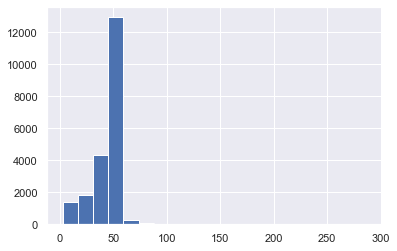

In [131]:
JFK_trips.fare_amount.hist(bins=20)

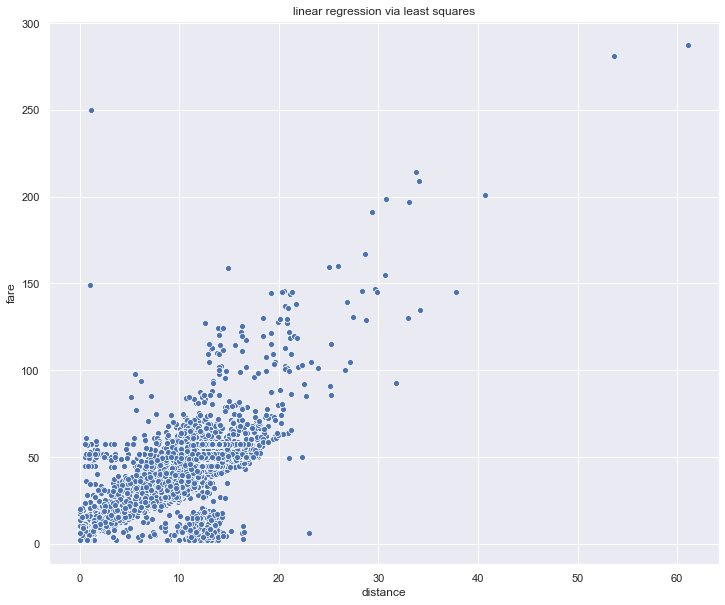

In [132]:
#df.plot.scatter(x='distance', y='fare_amount')
plt.figure(figsize=(12,10))
sns.scatterplot(x='distance',y='fare_amount', data=JFK_trips)
plt.xlabel('distance')
plt.ylabel('fare')
plt.title('linear regression via least squares');

In [133]:
EWR_trips = df[dropoff_pickup_in_bounding_box(df, EWR_xlim, EWR_ylim)]
EWR_trips.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,1260.00000,1260.00000,1260.00000,1260.00000,1260.00000,1260.00000,1260.00000
mean,69.83270,-73.98573,40.74925,-74.17851,40.69240,1.81429,10.96303
std,16.77302,0.03782,0.02424,0.00765,0.00455,1.36928,2.11396
min,2.50000,-74.22121,40.64228,-74.20897,40.67071,1.00000,0.00005
25%,62.30000,-73.99631,40.73666,-74.18153,40.68944,1.00000,10.15085
50%,70.00000,-73.98491,40.75399,-74.17761,40.69149,1.00000,11.04340
75%,79.25000,-73.97668,40.76293,-74.17720,40.69508,2.00000,11.66031
max,166.58000,-73.74367,40.84203,-74.00852,40.74343,6.00000,21.84806


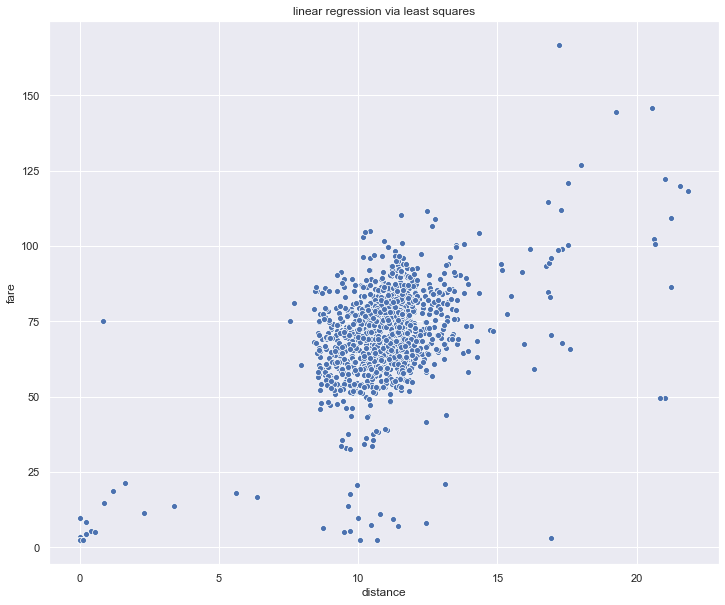

In [134]:
plt.figure(figsize=(12,10))
sns.scatterplot(x='distance',y='fare_amount', data=EWR_trips)
plt.xlabel('distance')
plt.ylabel('fare')
plt.title('linear regression via least squares');

In [135]:
#Examining airport trips
#Get coordinates of JFK, EWR which are fixed rate charges
#Check how many trips

## Base Models

- Current [domain knowledge](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page) suggests a very rough model:
    - Initial fare is $\$2.50$.  An additional $\$.50$ for every additional 1/5 mile.
$$ \text{fare} = 2.50 + 2.50 \times \text{distance (mi)}  $$
- Another model is to compute the mean charge per mile, $a$, and multiply that by the distance

In [136]:
x_train = df.drop(columns=['fare_amount'])
y_train = df['fare_amount']
add_distance(x_test)

NameError: name 'x_test' is not defined

In [137]:
def predict_fare( d ):
    return 2.5 * (1.0 + d)

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


y = df['fare_amount']
x = df['distance']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [142]:
from sklearn.metrics import mean_squared_error

print('Test RMSE for base model %.3f ' % mean_squared_error(predict_fare(x_test), y_test) ** 0.5)

Test RMSE for base model 6.083 


In [143]:
a = df['fare_amount'].mean() / df['distance'].mean()

In [144]:
print('Test RMSE for base model %.3f ' % mean_squared_error(a*x_test, y_test) ** 0.5)

Test RMSE for base model 5.371 


### Linear Regression Model via three methods
- Since the fare amounts are hidden (for the purposes of the competition) in 'test.csv', we'll split off more of the training set to use for testing.
- We'll do three methods for linear regression: implement it by hand, numpy.linalg, and scikitlearn's linearRegression

In [145]:
def get_augmented ( X ):
    return np.vstack([X, np.ones(len(X))]).T
A = get_augmented ( x_train)

1. **Ordinary Least Squares** [by hand](https://en.wikipedia.org/wiki/Linear_least_squares) using the [Moore-Penrose pseudoinverse](https://en.wikipedia.org/wiki/Moore-Penrose_inverse):
$${\bf w} = ({\bf X}^T{\bf X})^{-1} {\bf X}^T {\bf y} $$

In [146]:
MPInv = np.matmul(np.linalg.inv(np.matmul(A.T,A)), A.T)
w = np.matmul(MPInv, y_train)
print(w)

[3.79045941 3.35380044]


2. **Numpy's linalg package** and least squares

In [147]:
#Use numpy linear algebra least squares
(w, r, _, _) = np.linalg.lstsq(A, y_train, rcond=None)
m, c = w
print(m,c)

3.7904594106375407 3.353800442155896


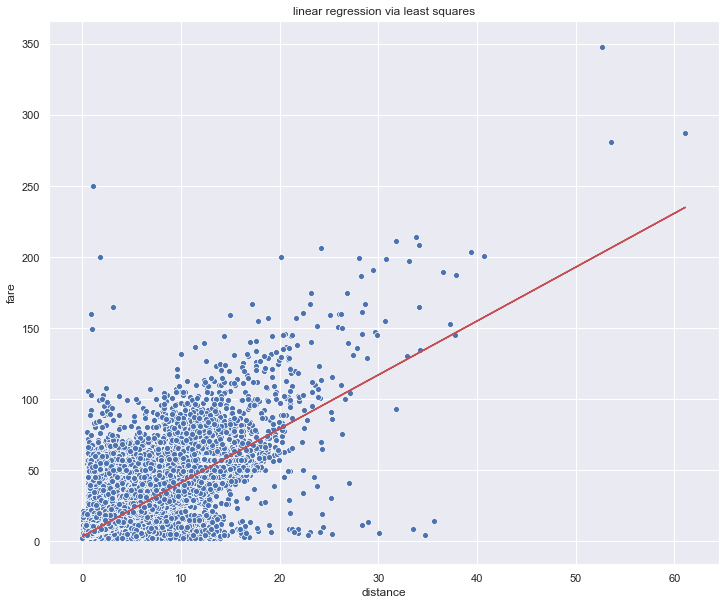

In [148]:
#df.plot.scatter(x='distance', y='fare_amount')
plt.figure(figsize=(12,10))
plt.plot(x, m*x + c, 'r')
sns.scatterplot(x='distance',y='fare_amount', data=df)
plt.xlabel('distance')
plt.ylabel('fare')
plt.title('linear regression via least squares');

In [149]:
y_pred = m*x_test+c

print("Test RMSE: %.3f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE: 4.010


3. **scikit-learn** Linear Regression

    - Note that from the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) scikit-learn wraps scipy's least squares implemenetation.

In [150]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x_train.values.reshape(-1,1), y_train)

In [151]:
y_pred = reg.predict(x_test.values.reshape(-1,1))

print("Test RMSE: %.3f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE: 4.010


In [152]:
print(reg.coef_, reg.intercept_)

[3.79045941] 3.353800442155899


### Validating the assumptions behind (multiple) linear regression

There are five main assumptions for linear regression:
1. The first assumption is linearity, this is violated due to our scatter plot above.
2. Homoscedasticity (constant variance of error/residuals)
3. Normal distribution of error terms
4. No autocorrelation in the residuals
5. No multicollinearity between the features

#### Check Homoscedasticity
- Plot residuals vs. predicted value.
- We'll use the package yellowbrick for this task.

In [153]:
#Check homoscedascicity 
from yellowbrick.regressor import ResidualsPlot;

/Users/kelly/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


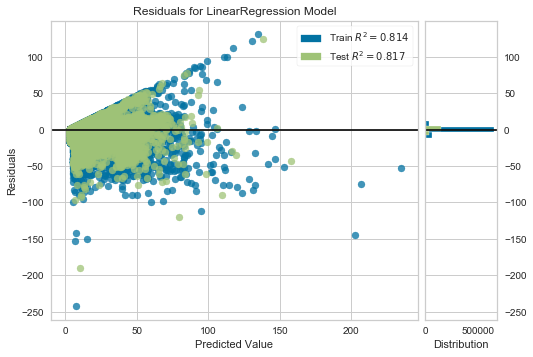

In [154]:
reg = LinearRegression()
visualizer = ResidualsPlot(reg)
visualizer.fit(x_train.values.reshape(-1,1),y_train)
visualizer.score(x_test.values.reshape(-1,1),y_test)
visualizer.poof()

#### Check independence of residuals

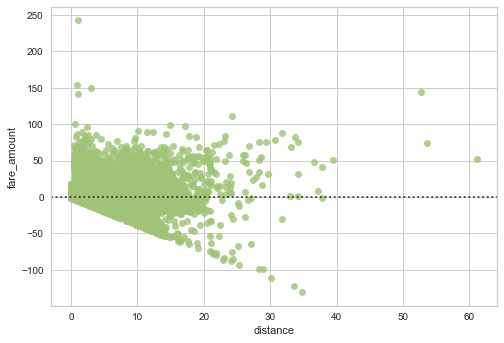

In [155]:
sns.residplot(x_train, y_train, lowess=False, color="g")

#### Check normal distribution of error terms
- TODO

### Multiple Linear Regression
- We will now incorporate more aspects of the data as independent variables

Some [domain knowedge](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page):
- Plus 50 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped.
- Plus 50 cents MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
- Plus 30 cents Improvement Surcharge.
- Plus 50 cents overnight surcharge 8pm to 6am.
- Plus 1.00 rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.
- Plus New York State Congestion Surcharge of 2.50 (Yellow Taxi) or 2.75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.

In [156]:
df['pickup_datetime'] = df.pickup_datetime.dt.tz_convert('US/Eastern')

In [157]:
df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['day'] = df.pickup_datetime.dt.day
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

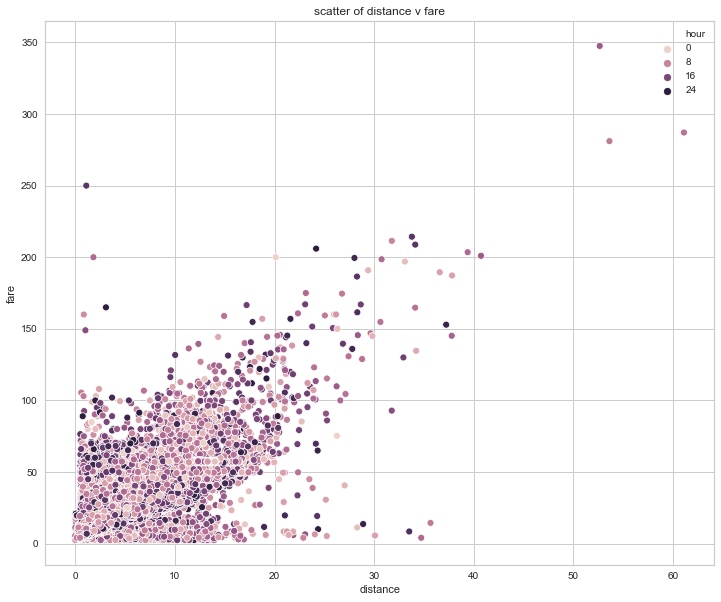

In [158]:
#df.plot.scatter(x='distance', y='fare_amount')
plt.figure(figsize=(12,10))
sns.scatterplot(x="distance", y="fare_amount", hue='hour', data=df)
plt.xlabel('distance')
plt.ylabel('fare')
plt.title('scatter of distance v fare');

In [159]:
#Model rush hour
def rush_hour ( weekday, hour ):
    if weekday < 5 and hour >= 16 and hour <= 20:
        return 1
    return 0
df['rush_hour'] = [rush_hour (w, h) for w,h in zip(df['weekday'],df['hour'])] 

In [206]:
#X = df.drop(columns=['key', 'pickup_datetime','fare_amount'])
X = df[ ['distance', 'year'] ]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [207]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [208]:
print("Test RMSE: $%.3f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE: $3.894


In [209]:
print(reg.coef_)

[3.78078475 0.51364787]


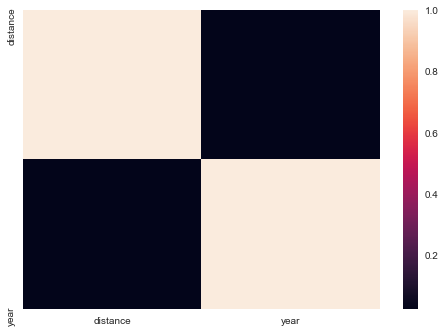

In [210]:
#Check multicollinearity
sns.heatmap(X.corr())

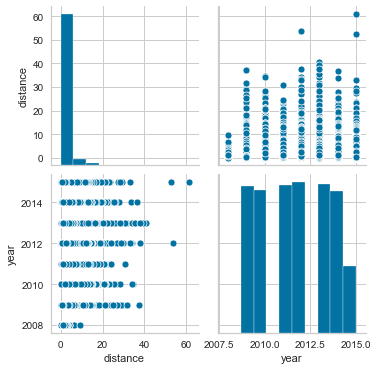

In [211]:
g = sns.pairplot(X)

### Back To Exploration
Let's return to data exploration, creating histograms based on time.

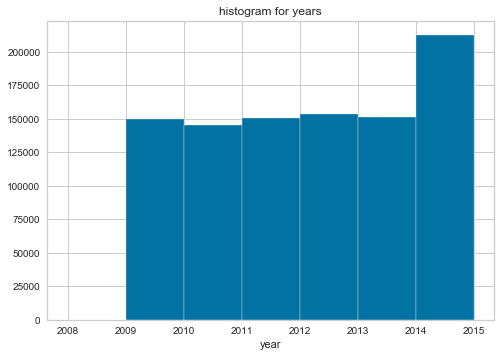

In [212]:
df.year.hist(bins=7)
plt.xlabel('year')
plt.title('histogram for years');

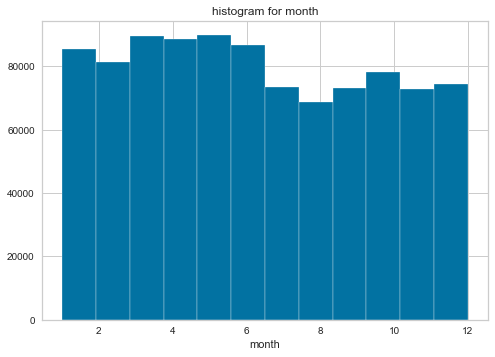

In [213]:
df.month.hist(bins=12)
plt.xlabel('month')
plt.title('histogram for month');

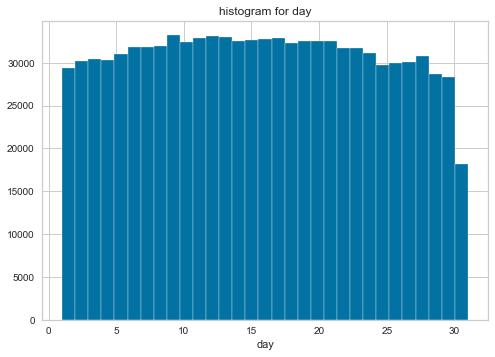

In [214]:
df.day.hist(bins=31)
plt.xlabel('day')
plt.title('histogram for day');

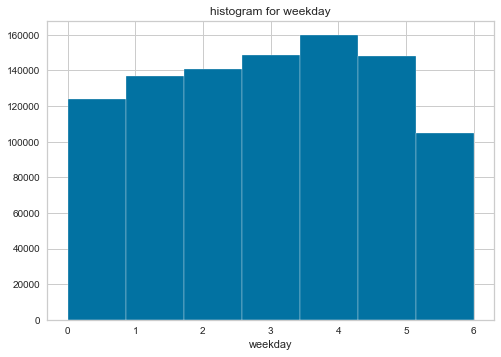

In [215]:
df.weekday.hist(bins=7)
plt.xlabel('weekday')
plt.title('histogram for weekday');

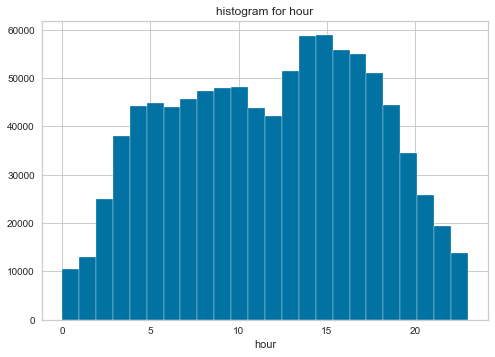

In [216]:
df.hour.hist(bins=24)
plt.xlabel('hour')
plt.title('histogram for hour');